In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy.cluster.hierarchy as hac
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
import matplotlib.pyplot as plt
from itertools import product
from datetime import timedelta

%matplotlib inline

class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'

In [2]:
# загрузка данных
data = pd.read_csv('..\\DATA\\aggregated\\!All.csv', index_col=0, parse_dates=True )
# загрузка идентификаторов ячеек, полученных на 2 неделе
regions = pd.read_csv('regions to analyse.csv', header=None, names=['region'])

In [3]:
# оставляем только нужные зоны
data = data[data.columns.intersection([str(x) for x in regions.region.values])]
data.shape

(28488, 102)

In [4]:
data.head(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2013-04-01 00:00:00,15,37,18,21,59,130,215,261,282,49,...,10,0,6,191,60,79,4,188,78,66
2013-04-01 01:00:00,4,14,8,12,38,53,205,169,218,27,...,12,0,1,51,0,11,5,126,41,31


На больших данных (3 года) сделаем регрессию Фурье-компонентами (3 штуки) с годовым периодом и полиномом 3й степени для тренда и запишем результат в таблицу для дальнейшего использования. Оптимальное количество компонент было определено на 3й неделе. Причем, нужен именно результат регресии, а не признаки. Поскольку в противном случае пришлось бы использовать все данные за три года. Считаю это нецелесообразным - ворочать такими большими матрицами, когда всю годовую закономерность можно выделить отдельными рядами. Недельную сезонность и, вообще, прогнозирование будем делать на данных за полгода. Разумеется, данные для обучения линейной модели будем использовать только __до апреля__ включительно.

In [5]:
#функция для создания фурье-компонент  и тренда годовой сезонности
def regress_compY_f(data, T_yearly=3):

    tau_y = 8766
    T_yearly = T_yearly # Количество Фурье-компонент
    
    # инициируем матрицу признаков для регресии
    exog = pd.DataFrame(index=data.index)
    exog['Hours']= (data.index-data.index.min()) / np.timedelta64(1, 'h')
    
    # компоненты для учета годовой сезонности
    for Ty in range(1, T_yearly+1):
        sin_lst_y=[]; cos_lst_y=[]
        
        for h in range(len(exog)):
            sin_lst_y.append(np.sin(exog.Hours[h]*Ty*2*np.pi/tau_y))
            cos_lst_y.append(np.cos(exog.Hours[h]*Ty*2*np.pi/tau_y))
            
        exog['Sin_y'+str(Ty)] = sin_lst_y
        exog['Cos_y'+str(Ty)] = cos_lst_y
        
    exog.drop(['Hours'], axis=1, inplace=True)

    return exog

In [6]:
#функция для создания компонент учета тренда
def regress_compY_t(data,T_trend=3):
    T_trend = T_trend # Количество членов в полиноме, учитывающем тренд
    
    # инициируем матрицу признаков для регресии
    exog = pd.DataFrame(index=data.index)
    
    # компоненты для учета тренда
    exog['Hours']= (data.index-data.index.min()) / np.timedelta64(1, 'h')

    for Th in range(2, T_trend+1):    
        exog['Hours**'+str(Th)]=(exog.Hours)**Th
        
    return exog

In [ ]:
# Добавляем регрессионные признаки в выборку
%%time
ind_begin = len(data[data.index<np.datetime64('2016-05-01 00:00:00')]) # индекс данных по апрель 2016

regr_y_f = pd.DataFrame(index=data.index)
regr_y_t = pd.DataFrame(index=data.index)

for arr in data.columns:
    col = data[str(arr)]
    
    # Компоненты для регрессии по Фурье
    exog_f = regress_compY_f(col, 3)
    exog_f = sm.add_constant(exog_f) # добавляем свободный член для регресии
    
    # Компоненты для регрессии тренда
    exog_t = regress_compY_t(col, 3)
    exog_t = sm.add_constant(exog_t) # добавляем свободный член для регресии 
    
    # обучаем линейную модель на данных по апрель 2016
    exog_f_train = exog_f[:ind_begin] # Фурье
    exog_t_train = exog_t[:ind_begin] # тренд
    
    target = col[:ind_begin]
    
    model_f = sm.OLS(target, exog_f_train)
    results_f = model_f.fit()
    
    model_t = sm.OLS(target, exog_t_train)
    results_t = model_t.fit()
    
    # аппроксимация на все данные
    res_f = results_f.predict(exog_f)
    res_t = results_t.predict(exog_t)
    
    # запись в df
    df_y_f   = pd.DataFrame(res_f, index=data.index, columns=[str(arr)])#str(arr)
    regr_y_f = regr_y_f.join(df_y_f)
    
    df_y_t   = pd.DataFrame(res_t, index=data.index, columns=[str(arr)])#str(arr)
    regr_y_t = regr_y_t.join(df_y_t)

In [7]:
# Поскольку операци довольно долгая, запишем результат в файл
#regr_y_f.to_csv('regr_y_f_allData.csv')
#regr_y_t.to_csv('regr_y_t_allData.csv')

# Зачитываем данные
regr_y_f = pd.read_csv('regr_y_f_allData.csv', index_col=0, parse_dates=True)
regr_y_t = pd.read_csv('regr_y_t_allData.csv', index_col=0, parse_dates=True)

In [8]:
regr_y_f.tail(2)

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-06-30 22:00:00,74.639470,148.127633,99.174373,75.850639,217.129742,306.526881,350.578352,396.071487,487.033335,167.304859,...,5.612571,15.331863,9.765709,210.549592,172.167430,79.258267,8.393891,134.388494,44.477001,57.097509
2016-06-30 23:00:00,74.644212,148.123958,99.164601,75.847384,217.127019,306.490056,350.542208,396.027914,486.979900,167.285857,...,5.612133,15.327890,9.764689,210.524589,172.148955,79.253567,8.393725,134.387890,44.469704,57.097286


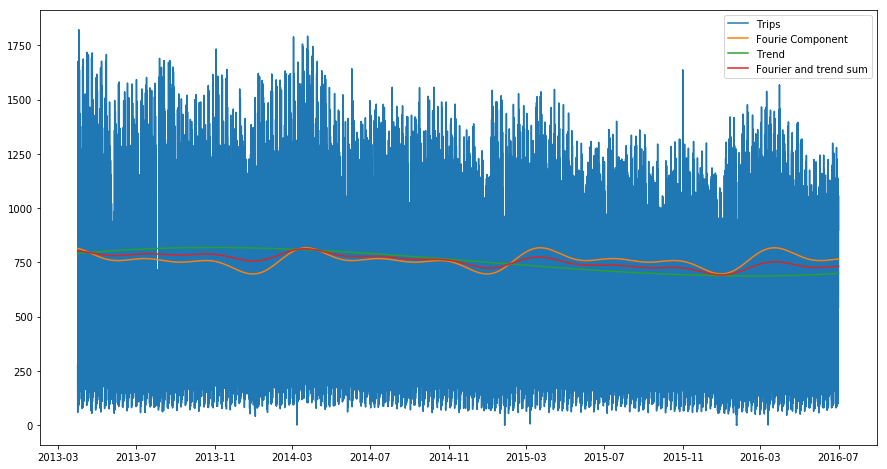

In [9]:
#Посмотрим на графики поездок по одной из зон с наложением трендовой и Фурье-компонент

plt.figure(figsize=(15,8))
plt.plot(data['1231'], label = "Trips")
plt.plot(regr_y_f['1231'], label = "Fourie Component")
plt.plot(regr_y_t['1231'], label = "Trend")
plt.plot(0.5*(regr_y_f['1231'] + regr_y_t['1231']), label = "Fourier and trend sum")

plt.legend(loc=1)


Как видно из графика, в данных есть месячная сезонность с выраженными пиками в апреле. Присутствует годовой тренд.

Начнем собирать в таблицу признаки для регресии. Я решил создать DataFrame с мультииндексом, в котором по строкам будет дата-время, а постолбцам - зоны/признаки. Таким образом, необходимость в категориальном признаке номера зоны отпадает. Для каждого временного сдвига для каждой зоны будет строиться своя модель.

In [10]:
ind_nov16 = len(data[data.index<np.datetime64('2015-10-01 00:00:00')]) # индекс данных до ноября 2015 
                                                                # (не будут использоваться при дальнейшем моделировании).
    
dBaseTr = data.copy()[ind_nov16:]
dBaseTr.columns=pd.MultiIndex.from_product([dBaseTr.columns, ['Trips']])

dBaseTrY = regr_y_f.copy()[ind_nov16:]
dBaseTrY.columns=pd.MultiIndex.from_product([dBaseTrY.columns, ['FourieY']])

dBaseTrT = regr_y_t.copy()[ind_nov16:]
dBaseTrT.columns=pd.MultiIndex.from_product([dBaseTrT.columns, ['TrendY']])

dBase = pd.concat([dBaseTr, dBaseTrY, dBaseTrT], axis=1)

dBase.sort_index(axis=1, inplace=True)

In [11]:
dBase.tail(2)

1075                         1076                    \
                       FourieY     TrendY Trips     FourieY      TrendY Trips   
2016-06-30 22:00:00  74.639470  58.351984   106  148.127633  125.649912   168   
2016-06-30 23:00:00  74.644212  58.350867    85  148.123958  125.647623   130   

                          1077                        1125  ...   2069  \
                       FourieY     TrendY Trips    FourieY  ...  Trips   
2016-06-30 22:00:00  99.174373  81.215626   103  75.850639  ...     12   
2016-06-30 23:00:00  99.164601  81.215288    86  75.847384  ...     38   

                           2118                         2119                   \
                        FourieY      TrendY Trips    FourieY     TrendY Trips   
2016-06-30 22:00:00  134.388494  124.060578   206  44.477001  16.630380   146   
2016-06-30 23:00:00  134.387890  124.055934   173  44.469704  16.625125   119   

                          2168                   
                       FourieY     TrendY Trips  
2016-06-30 22:00:00  57.097509  59.092537     0  
2016-06-30 23:00:00  57.097286  59.089780     0  

[2 rows x 306 columns]

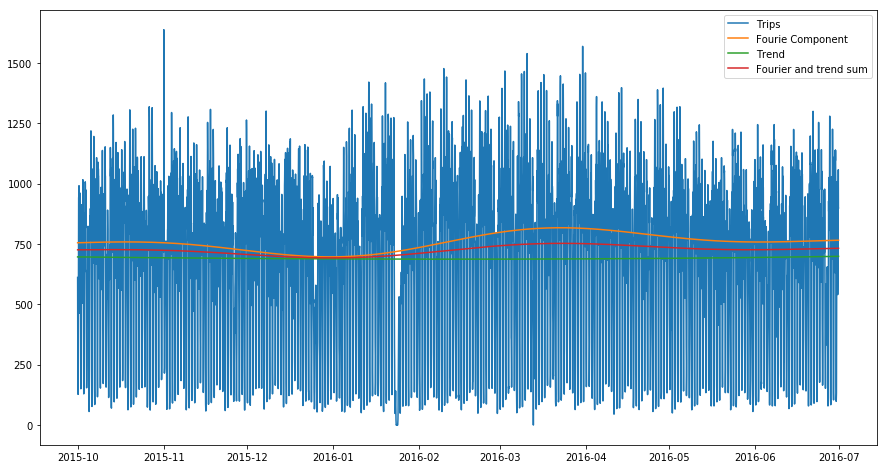

In [12]:
#Посмотрим на графики поездок с наложением трендовой и Фурье-компонент

plt.figure(figsize=(15,8))
plt.plot(dBase['1231', 'Trips'], label = "Trips")
plt.plot(dBase['1231', 'FourieY'], label = "Fourie Component")
plt.plot(dBase['1231', 'TrendY'], label = "Trend")
plt.plot(0.5*(dBase['1231', 'FourieY'] + dBase['1231', 'TrendY']), label = "Fourier and trend sum")

plt.legend(loc=1)

In [13]:
#функция для создания фурье-компонент  и тренда годовой сезонности
def regress_compW_f(data, T_weekly=5):

    tau_w = 168
    T_weekly = T_weekly # Количество Фурье-компонент
    
    # инициируем матрицу признаков для регресии
    exog = pd.DataFrame(index=data.index)
    exog['Hours']= (data.index-data.index.min()) / np.timedelta64(1, 'h')
    
    # компоненты для учета недельной сезонности
    for Tw in range(1, T_weekly+1):
        sin_lst_w=[]; cos_lst_w=[] ;
        
        for h in range(len(exog)):
            sin_lst_w.append(np.sin(exog.Hours[h]*Tw*2*np.pi/tau_w))
            cos_lst_w.append(np.cos(exog.Hours[h]*Tw*2*np.pi/tau_w))
       
        exog['Sin_w'+str(Tw)] = sin_lst_w
        exog['Cos_w'+str(Tw)] = cos_lst_w
        
    exog.drop(['Hours'], axis=1, inplace=True)

    return exog

In [15]:
%%time
# добавляем недельные Фурье-компоненты в выборку
for col in data.columns:
    
    exog=regress_compW_f(dBase[col]['Trips'])
    
    for app in exog.columns:
        dBase[col, app] = exog[app]
    

dBase.sort_index(axis=1, inplace=True)

Wall time: 5min 53s


In [21]:
# dBase.to_csv('dBase_exogFT.csv')
# Зачитываем данные
dBase = pd.read_csv('dBase_exogFT.csv', header=[0,1], index_col=0, parse_dates=True)

In [22]:
# добавляем признаки часа и дня недели в выборку:
for col in data.columns:
    dBase[col, 'DoW'] = dBase.index.dayofweek # день недели
    dBase[col, 'Hour'] = dBase.index.hour # час

dBase.sort_index(axis=1, inplace=True)

In [24]:
# добавляем признаки, связанные со сдигом
for col in data.columns:
    
    for t in range(1,7):
        dBase[col, 'Trips_'+str(t)] = dBase[col, 'Trips'].shift(t) # сдвиг на t часов
        
    dBase[col, 'Trips_24'] = dBase[col, 'Trips'].shift(24) # сдвиг на сутки
    dBase[col, 'Trips_48'] = dBase[col, 'Trips'].shift(48) # сдвиг на 2 суток
    
    

In [25]:
# добавляем признаки, учитывающие сумму количества проездок
for col in data.columns:

        dBase[col, 'Trips_s12'] = dBase[col, 'Trips'].rolling(12).sum() # Сумма поездок за последние 12 часов
            
        dBase[col, 'Trips_s24'] = dBase[col, 'Trips'].rolling(24).sum() # Сумма поездок за последние 24 часа

        dBase[col, 'Trips_s168'] =  dBase[col, 'Trips'].rolling(168).sum() # Сумма поездок за последнюю неделю
        
dBase.sort_index(axis=1, inplace=True)            

In [28]:
dBase.tail(2)

1075                                              \
                       Cos_w1    Cos_w2    Cos_w3    Cos_w4    Cos_w5 DoW   
2016-06-30 22:00:00  0.680173 -0.074730 -0.781831 -0.988831 -0.563320   3   
2016-06-30 23:00:00  0.652287 -0.149042 -0.846724 -0.955573 -0.399892   3   

                                                           ...       2168  \
                       FourieY Hour    Sin_w1    Sin_w2    ...    Trips_2   
2016-06-30 22:00:00  74.639470   22  0.733052  0.997204    ...        0.0   
2016-06-30 23:00:00  74.644212   23  0.757972  0.988831    ...        1.0   

                                                                       \
                    Trips_24 Trips_3 Trips_4 Trips_48 Trips_5 Trips_6   
2016-06-30 22:00:00      2.0     1.0     1.0      2.0     1.0     2.0   
2016-06-30 23:00:00      1.0     0.0     1.0      1.0     1.0     1.0   

                                                    
                    Trips_s12 Trips_s168 Trips_s24  
2016-06-30 22:00:00       9.0      227.0      27.0  
2016-06-30 23:00:00       9.0      226.0      27.0  

[2 rows x 2652 columns]

In [29]:
dBase['1075'].head(5)

,Cos_w1,Cos_w2,Cos_w3,Cos_w4,Cos_w5,DoW,FourieY,Hour,Sin_w1,Sin_w2,...,Trips_2,Trips_24,Trips_3,Trips_4,Trips_48,Trips_5,Trips_6,Trips_s12,Trips_s168,Trips_s24
2015-10-01 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,3,66.651707,0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 01:00:00,0.999301,0.997204,0.993712,0.988831,0.982566,3,66.648335,1,0.037391,0.074730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 02:00:00,0.997204,0.988831,0.974928,0.955573,0.930874,3,66.644969,2,0.074730,0.149042,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 03:00:00,0.993712,0.974928,0.943883,0.900969,0.846724,3,66.641610,3,0.111964,0.222521,...,27.0,NaN,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-10-01 04:00:00,0.988831,0.955573,0.900969,0.826239,0.733052,3,66.638257,4,0.149042,0.294755,...,15.0,NaN,27.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Поскольку операци по созданию признаков довольно долгие, запишем результат в файл
#dBase.to_csv('dBase.csv')

dBase = pd.read_csv('dBase.csv', header=[0,1], index_col=0, parse_dates=True)

In [31]:
print 'Принаки получаются такие: ', dBase['1075'].columns
print 'Размерность матрицы признаков: ', dBase.shape

Принаки получаются такие:  Index([u'Cos_w1', u'Cos_w2', u'Cos_w3', u'Cos_w4', u'Cos_w5', u'DoW',
       u'FourieY', u'Hour', u'Sin_w1', u'Sin_w2', u'Sin_w3', u'Sin_w4',
       u'Sin_w5', u'TrendY', u'Trips', u'Trips_1', u'Trips_2', u'Trips_24',
       u'Trips_3', u'Trips_4', u'Trips_48', u'Trips_5', u'Trips_6',
       u'Trips_s12', u'Trips_s168', u'Trips_s24'],
      dtype='object')
Размерность матрицы признаков:  (6576, 2652)


Поучается 2652/102 = 26 признаков на каждую зону

На прошлой неделе были получены модели ARIMA для прогнозирования количества поездок на май и июнь 2016. Для формирования признака, учитывающего эти модели поступим следующим образом: обучающая выборка является результатом аппроксимации на обучающем множестве с ноября 2015 по апрель 2016, а модели со сдвигом (1-6 дней) на май и июнь будут служить данными для каждой из 6 текущих задач регрессии.

In [27]:
# загрузим модели ARIMA с прошлой недели (обучающая выборка - по апрель 2016)
df_arima_train = pd.read_csv('df_arima_train.csv', index_col=0, parse_dates=True)

Сформируем 6 выборок для каждой из шести задач прогнозирования {y}_{T+i|T}, i=1,...,6

In [28]:
# Загрузим прогнозы моделей ARIMA на май и июнь 2016
arima_may = pd.read_csv('!arima_may.csv', index_col=0, parse_dates=True)
arima_june = pd.read_csv('!arima_june.csv', index_col=0, parse_dates=True)

In [29]:
arima_may.head()

,zone,int,trip
date,,,
2016-04-30 23:00:00,1075,1,64.442031
2016-04-30 23:00:00,1075,2,42.345508
2016-04-30 23:00:00,1075,3,26.207546
2016-04-30 23:00:00,1075,4,16.037482
2016-04-30 23:00:00,1075,5,13.655921


Так как в Питоне я новичок (например, не нашел как динамически объявлять переменные...), то код получается довольно громоздкий. Извиняйте.. 

In [30]:
# Для каждого значения сдвига содадим df, где по столбцам будет зона, по строкам - время
arima_may.zone = arima_may.zone.apply(str)
arima_june.zone = arima_june.zone.apply(str)

df_ar_m1 = pd.pivot_table(arima_may[(arima_may['int']==1)], columns=['zone'], index='date')
df_ar_j1 = pd.pivot_table(arima_june[(arima_june['int']==1)], columns=['zone'], index='date')

df_ar_m2 = pd.pivot_table(arima_may[(arima_may['int']==2)], columns=['zone'], index='date')
df_ar_j2 = pd.pivot_table(arima_june[(arima_june['int']==2)], columns=['zone'], index='date')

df_ar_m3 = pd.pivot_table(arima_may[(arima_may['int']==3)], columns=['zone'], index='date')
df_ar_j3 = pd.pivot_table(arima_june[(arima_june['int']==3)], columns=['zone'], index='date')

df_ar_m4 = pd.pivot_table(arima_may[(arima_may['int']==4)], columns=['zone'], index='date')
df_ar_j4 = pd.pivot_table(arima_june[(arima_june['int']==4)], columns=['zone'], index='date')

df_ar_m5 = pd.pivot_table(arima_may[(arima_may['int']==5)], columns=['zone'], index='date')
df_ar_j5 = pd.pivot_table(arima_june[(arima_june['int']==5)], columns=['zone'], index='date')

df_ar_m6 = pd.pivot_table(arima_may[(arima_may['int']==6)], columns=['zone'], index='date')
df_ar_j6 = pd.pivot_table(arima_june[(arima_june['int']==6)], columns=['zone'], index='date')

In [31]:
# Создание признака - модель ARIMA

trips_1 = df_arima_train.shift(-1)[df_arima_train.index<df_ar_m1.index[0]]
trips_2 = df_arima_train.shift(-2)[df_arima_train.index<df_ar_m2.index[0]]
trips_3 = df_arima_train.shift(-3)[df_arima_train.index<df_ar_m3.index[0]]
trips_4 = df_arima_train.shift(-4)[df_arima_train.index<df_ar_m4.index[0]]
trips_5 = df_arima_train.shift(-5)[df_arima_train.index<df_ar_m5.index[0]]
trips_6 = df_arima_train.shift(-6)[df_arima_train.index<df_ar_m6.index[0]]


arima_1 = pd.concat([trips_1, df_ar_m1['trip'], df_ar_j1['trip']]) 
arima_2 = pd.concat([trips_2, df_ar_m2['trip'], df_ar_j2['trip']]) 
arima_3 = pd.concat([trips_3, df_ar_m3['trip'], df_ar_j3['trip']]) 
arima_4 = pd.concat([trips_4, df_ar_m4['trip'], df_ar_j4['trip']]) 
arima_5 = pd.concat([trips_5, df_ar_m5['trip'], df_ar_j5['trip']]) 
arima_6 = pd.concat([trips_6, df_ar_m6['trip'], df_ar_j6['trip']]) 

In [32]:
arima_1.shape

(6570, 102)

Для построения регрессии буду пользоваться моделью OLS из statsmodels. Для учета взаимодействий между переменными зависимость отклика от признаков там нужно задавать формулой. Поэтому целевая переменная входит в состав датафрейма: (formula, data). Итак, формируем массивы данных для 6-и моделей.

In [33]:
# Целевая переменная - количество поездок (Y) - будет добавлена в каждую выборку с соответствующим сдвигом
X_1 = dBase.copy()
X_2 = dBase.copy()
X_3 = dBase.copy()
X_4 = dBase.copy()
X_5 = dBase.copy()
X_6 = dBase.copy()

for col in arima_1.columns:
      
    X_1[col, 'ARIMA'] = arima_1[col]  # добавляем столбец с данными по ARIMA  
    X_1[col, 'Y'] = X_1[col, 'Trips'].shift(-1) # целевая переменная - количество поездок на час вперед
    
    X_2[col, 'ARIMA'] = arima_2[col]  # добавляем столбец с данными по ARIMA  
    X_2[col, 'Y'] = X_2[col, 'Trips'].shift(-2) # целевая переменная - количество поездок на 2 часа вперед
        
    X_3[col, 'ARIMA'] = arima_3[col]  # добавляем столбец с данными по ARIMA  
    X_3[col, 'Y'] = X_3[col, 'Trips'].shift(-3) # целевая переменная - количество поездок на 3 часа вперед
    
    X_4[col, 'ARIMA'] = arima_4[col]  # добавляем столбец с данными по ARIMA  
    X_4[col, 'Y'] = X_4[col, 'Trips'].shift(-4) # целевая переменная - количество поездок на 4 часа вперед
    
    X_5[col, 'ARIMA'] = arima_5[col]  # добавляем столбец с данными по ARIMA  
    X_5[col, 'Y'] = X_5[col, 'Trips'].shift(-5) # целевая переменная - количество поездок на 5 часов вперед
    
    X_6[col, 'ARIMA'] = arima_6[col]  # добавляем столбец с данными по ARIMA  
    X_6[col, 'Y'] = X_6[col, 'Trips'].shift(-6) # целевая переменная - количество поездок на 6 часов вперед
   
X_1.sort_index(axis=1, inplace=True)
X_2.sort_index(axis=1, inplace=True)  
X_3.sort_index(axis=1, inplace=True)  
X_4.sort_index(axis=1, inplace=True)  
X_5.sort_index(axis=1, inplace=True)  
X_6.sort_index(axis=1, inplace=True)  


In [57]:
# сохранение обучающих выборок

X_1.to_csv('X_1.csv')
X_2.to_csv('X_2.csv')
X_3.to_csv('X_3.csv')
X_4.to_csv('X_4.csv')
X_5.to_csv('X_5.csv')
X_6.to_csv('X_6.csv')


#### 2. Формирование обучающей, тестовой и итоговой выборок

Фолды для обучения, кросс-валидации и результата будут определятся непосредственно при обращении к данным с помощью индексов:

In [34]:
ind_cv = len(X_1.index[X_1.index<np.datetime64('2016-05-01')])
ind_res = len(X_1.index[X_1.index<np.datetime64('2016-06-01')])
print 'Индекс начала фолда кросс-валидации: ', ind_cv
print 'Индекс начала фолда итоговой выборки: ', ind_res

Индекс начала фолда кросс-валидации:  5112
Индекс начала фолда итоговой выборки:  5856


#### 3. Построение моделей

Посмотрим на результат моделирования на час вперед по одной зоне

In [35]:
#Формирование строки для записи формулы в OLS
l1 = list(X_1['1075'].columns) # список всех переменных
l1.pop() # убираем последний элемент - целевую переменную Y
f0 = 'Y~' + '+'.join(l1)
f0

'Y~ARIMA+Cos_w1+Cos_w2+Cos_w3+Cos_w4+Cos_w5+DoW+FourieY+Hour+Sin_w1+Sin_w2+Sin_w3+Sin_w4+Sin_w5+TrendY+Trips+Trips_1+Trips_2+Trips_24+Trips_3+Trips_4+Trips_48+Trips_5+Trips_6+Trips_s12+Trips_s168+Trips_s24'

In [36]:
# Обучение модели и регрессия на июнь по "1180" зоне
mod = smf.ols(formula=f0, data=X_1['1180'][:ind_cv], missing='drop') # строим модель на обучающем множестве
res_test = mod.fit_regularized(L1_wt=0.9, alpha=1)
res = res_test.predict(X_1['1180'][ind_res:]) # предсказываем на июнь

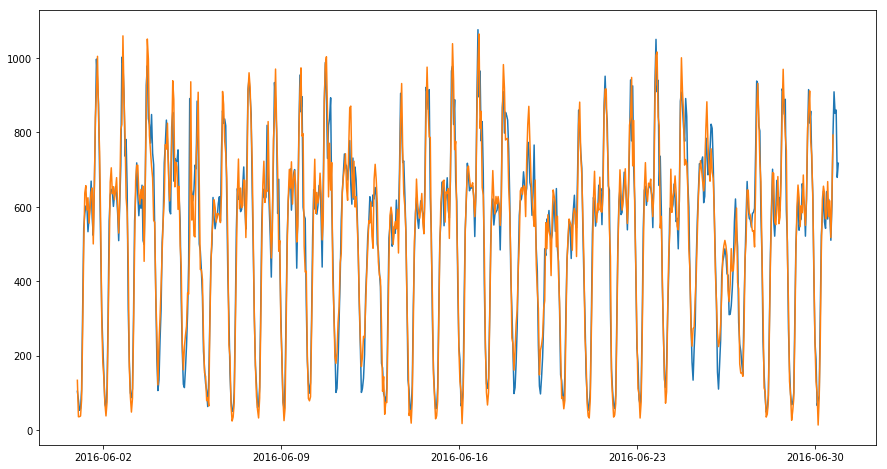

In [37]:
res[res<0]=0
plt.figure(figsize=(15,8))
plt.plot(X_1['1180', 'Y'][ind_res:])
plt.plot(res)

Посмотрим на значения коэффициентов при признаках:

In [38]:
res_test.params

Intercept     0.000000
ARIMA         0.978594
Cos_w1        0.000000
Cos_w2        0.000000
Cos_w3        0.000000
Cos_w4        0.000000
Cos_w5       -0.123899
DoW           0.000000
FourieY      -0.007122
Hour         -0.644982
Sin_w1        0.000000
Sin_w2        0.000000
Sin_w3        0.000000
Sin_w4        0.000000
Sin_w5        0.000000
TrendY        0.000000
Trips         0.015840
Trips_1       0.006206
Trips_2      -0.024399
Trips_24      0.052436
Trips_3      -0.028823
Trips_4      -0.019146
Trips_48      0.006221
Trips_5      -0.023832
Trips_6       0.022323
Trips_s12     0.005253
Trips_s168   -0.000234
Trips_s24     0.000564
dtype: float64

Видно, что коэффициент при ARIMA самый большой. То есть прогноз определяется именно этим признаком (что, в принципе, понятно). Построим модель, которая учитывает взаимодействия ARIMA со всеми остальными перменными. Это записывается в формуле: 

ARIMA(x)Cos_w1 + ARIMA(x)Cos_w2 + ... 

In [39]:
l1 = list(X_1['1075'].columns) # список всех переменных
l1.pop() # убираем последний элемент - целевую переменную Y
f1 = 'Y~' + '+ARIMA*'.join(l1)
f1

'Y~ARIMA+ARIMA*Cos_w1+ARIMA*Cos_w2+ARIMA*Cos_w3+ARIMA*Cos_w4+ARIMA*Cos_w5+ARIMA*DoW+ARIMA*FourieY+ARIMA*Hour+ARIMA*Sin_w1+ARIMA*Sin_w2+ARIMA*Sin_w3+ARIMA*Sin_w4+ARIMA*Sin_w5+ARIMA*TrendY+ARIMA*Trips+ARIMA*Trips_1+ARIMA*Trips_2+ARIMA*Trips_24+ARIMA*Trips_3+ARIMA*Trips_4+ARIMA*Trips_48+ARIMA*Trips_5+ARIMA*Trips_6+ARIMA*Trips_s12+ARIMA*Trips_s168+ARIMA*Trips_s24'

In [40]:
mod1 = smf.ols(formula=f1, data=X_1['1180'][:ind_cv], missing='drop') # строим модель на обучающем множестве
res_test1 = mod1.fit_regularized(L1_wt=0.9, alpha=1)
res1 = res_test1.predict(X_1['1180'][ind_res:]) # предсказываем на июнь

Сравним ошибку по модели с ошибкой по ARIMA для одной зоны на июне: 

In [41]:
res[res<0]=0
err_model = np.abs(res1[:-6] - X_1['1180', 'Y'][ind_res:-6].values).sum()/714
err_arima = np.abs(arima_1['1180'][-714:].values - X_1['1180', 'Y'][-720:-6].values).sum()/714
print 'Ошибка по модели: ', err_model
print 'Ошибка по ARIMA: ', err_arima

Ошибка по модели:  50.41107177216942
Ошибка по ARIMA:  53.13164965626051


Ошибка уменьшилась. Можно приступать к моделированию.

Используем метод fit_regularized, которому можно подавать 2 параметра регуляризации: L1_wt - доля регуляризации L1, alpha-штрафы при коэффициентах. Поскольку первый параметр - ARIMA - вносит самый большой вклад, будем менять долю штрафа его вклада в модель.

Поскольку в модели smf.ols для fit_regularized нет score, по которому можно сравнивать результаты, будем использовать функционал ошибки прогноза, указанный в задании

In [42]:
# функция цикла подбора параметров регуляризаторов
def regular_param_fit(X, parameters_list, shift):
    
    best_score = float("inf")

    model_params = []
    best_param = []
    
    for param in parameters_list:    
        print param
        score = 0
        for col in data.columns: # по всем зонам
        
            mod = smf.ols(formula=f1, data=X[col][:ind_cv]) #обучаем на данных до апреля
            res_train = mod.fit_regularized(L1_wt=param[0], alpha=list([param[1]])+[0.2]*52)
                    
            # считаем score на кросс-валидации и суммируем по всем зонам
            score += np.abs(res_train.predict(X[col][ind_cv:ind_res])-X[col, 'Y'][ind_cv:ind_res]).mean()
      
        if score < best_score:
            best_param = param
            best_model_params = res_train.params
            best_score = score
            print best_score
            model_params.append(res_train.params.values)
                
 
    # сохранияем параметры в файлы
    pd.DataFrame(pd.DataFrame([best_param])).to_csv('regular_params-'+str(shift)+'.csv', header=False)
    pd.DataFrame(pd.DataFrame([best_score])).to_csv('best_score-'+str(shift)+'.csv', header=False)
    
    return {'best_param': best_param, 'best_score': best_score}        
        

In [43]:
# определим наборы параметров
def param_product():
   
    L1_wt = np.arange(0.7, 1, 0.1)
    alpha = np.arange(0.2, 1, 0.2)
#    alpha = np.arange(1, 10, 2)

    params = product(L1_wt, alpha)
    parameters_list = list(params)

    return parameters_list

In [44]:
%%time
# подбор параметров регуляризации (гиперпараметров) для каждой из 6-и моделей
bestParam_df = []
best_param = []

parameters_list = param_product()   

print 'shift = 1'
result1 = regular_param_fit(X_1, param_product(), 1)
bestParam_df.append([1, result1['best_param']])

print 'shift = 2'
result2 = regular_param_fit(X_2, param_product(), 2)
bestParam_df.append([2, result2['best_param']])

print 'shift = 3'
result3 = regular_param_fit(X_3, param_product(), 3)
bestParam_df.append([3, result3['best_param']])

print 'shift = 4'
result4 = regular_param_fit(X_4, param_product(), 4)
bestParam_df.append([4, result4['best_param']])

print 'shift = 5'
result5 = regular_param_fit(X_5, param_product(), 5)
bestParam_df.append([5, result5['best_param']])

print 'shift = 6'
result6 = regular_param_fit(X_6, param_product(), 6)
bestParam_df.append([6, result6['best_param']])

Перебор работает долго (у меня - 6 часов), поэтому сохраняю все результаты в файл

#### 4. Расчет ошибки на кросс-валидации - май 2016

Оптимальные параметры регуляризации

In [46]:
bestParam = pd.DataFrame(bestParam_df, columns=['shift', 'params (L1, alpha)'])
bestParam

,shift,"params (L1, alpha)"
0,1,"(0.9, 3)"
1,2,"(0.9, 6)"
2,3,"(0.8, 5)"
3,4,"(1, 0.2)"
4,5,"(1, 0.2)"
5,6,"(1, 0.4)"


Поскольку в процессе поиска гиперпараметров мы использовали необходимый функционал ошибки, просто сложим получившиеся значения и разделим на (102*6)

In [47]:
r1 = result1['best_score']
r2 = result2['best_score']
r3 = result3['best_score']
r4 = result4['best_score']
r5 = result5['best_score']
r6 = result6['best_score']

err_may = (r1 + r2 + r3 + r4 + r5 + r6)/(102*6)

print 'Ошибка регрессионной модели на мае 2016: ', err_may

Ошибка на мае по ARIMA на 4й неделе:  28.3. Таким образом, модель стала точнее на 6%

#### 5. Построение итогового прогноза для Kaggle

In [48]:
f1

'Y~ARIMA+ARIMA*Cos_w1+ARIMA*Cos_w2+ARIMA*Cos_w3+ARIMA*Cos_w4+ARIMA*Cos_w5+ARIMA*DoW+ARIMA*FourieY+ARIMA*Hour+ARIMA*Sin_w1+ARIMA*Sin_w2+ARIMA*Sin_w3+ARIMA*Sin_w4+ARIMA*Sin_w5+ARIMA*TrendY+ARIMA*Trips+ARIMA*Trips_1+ARIMA*Trips_2+ARIMA*Trips_24+ARIMA*Trips_3+ARIMA*Trips_4+ARIMA*Trips_48+ARIMA*Trips_5+ARIMA*Trips_6+ARIMA*Trips_s12+ARIMA*Trips_s168+ARIMA*Trips_s24'

In [49]:
def model_res(X, param):
    
    df = pd.DataFrame(index=X['1075'][(ind_res-1):].index)
    
    mod = smf.ols(formula=f1, data=X['1075'][:ind_cv])
    res_0 = mod.fit_regularized(L1_wt=param[0], alpha=[param[1]]+[0.2]*55)    
    df_param = pd.DataFrame(res_0.params.index)

    score = 0
    #for param in param_lst:   
    for col in data.columns: # по всем зонам
        
        mod = smf.ols(formula=f1, data=X[col][:ind_cv]) # обучаем только на данных до апреля
        res_train = mod.fit_regularized(L1_wt=param[0], alpha=[param[1]]+[0.2]*55)
        res = res_train.predict(X[col][(ind_res-1):])
        
        # df для предсказания целевой переменной
        pd_res = pd.DataFrame(res, columns=[col])
        df = df.join(pd_res)
        # df для  параметров моделей
        pd_testparam = pd.DataFrame(res_train.params, columns=[col])
        df_param = df_param.join(pd_testparam)
                   
        # считаем score на кросс-валидации и суммируем по всем зонам
        score += np.abs(res-X[col, 'Y'][(ind_res-1):]).mean()
        
        #kag_lst1.append([str(col)+'_'+time.strftime('%Y-%m-%d_%#H')+'_'+str(item), predicted_value[0]])
        
    return {'Y': df, 'PAR': df_param, 'score': score}

In [50]:
%%time
# обучение моделей

param_lst = bestParam[:]['params (L1, alpha)'] # гиперпараметры для моделей

return1 = model_res(X_1, param_lst[0])
Y_1 = return1['Y']
ModelOLS_1 = return1['PAR']
err_1 = return1['score']

return2 = model_res(X_2, param_lst[1])
Y_2 = return2['Y']
ModelOLS_2 = return2['PAR']
err_2 = return2['score']

return3 = model_res(X_3, param_lst[2])
Y_3 = return3['Y']
ModelOLS_3 = return3['PAR']
err_3 = return3['score']

return4 = model_res(X_4, param_lst[3])
Y_4 = return4['Y']
ModelOLS_4 = return4['PAR']
err_4 = return4['score']

return5 = model_res(X_5, param_lst[4])
Y_5 = return5['Y']
ModelOLS_5 = return5['PAR']
err_5 = return5['score']

return6 = model_res(X_6, param_lst[5])
Y_6 = return6['Y']
ModelOLS_6 = return6['PAR']
err_6 = return6['score']


Wall time: 14min 24s


In [51]:
# удаляем строки с Nan (после 17:00 30 июня 2016)
for Y in [Y_1, Y_2, Y_3, Y_4, Y_5, Y_6]:
    Y.dropna(inplace=True)

In [52]:
# соберем все данные в одну таблицу, вытянем в строку и добавим параметр сдвига

Y_1['date'] = Y_1.index
Y_11 = Y_1.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_11['shift'] = 1

Y_2['date'] = Y_2.index
Y_22 = Y_2.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_22['shift'] = 2

Y_3['date'] = Y_3.index
Y_33 = Y_3.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_33['shift'] = 3

Y_4['date'] = Y_4.index
Y_44 = Y_4.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_44['shift'] = 4

Y_5['date'] = Y_5.index
Y_55 = Y_5.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_55['shift'] = 5

Y_6['date'] = Y_6.index
Y_66 = Y_6.melt(id_vars='date', var_name='Zone', value_name='Trips')
Y_66['shift'] = 6


tot_y = pd.concat([Y_11,Y_22, Y_33, Y_44, Y_55, Y_66], ignore_index=True)

In [53]:
tot_y = tot_y.sort_values(['Zone', 'date', 'shift'])
tot_y.date = pd.to_datetime(tot_y.date)

In [54]:
to_Kagle = []
for index, row in tot_y.iterrows():
    to_Kagle.append([str(row['Zone'])+'_'+row['date'].strftime('%Y-%m-%d_%#H')+'_'+str(row['shift']), row['Trips']])

In [55]:
# запись в файл
pd.DataFrame(to_Kagle, columns=['id', 'y']).to_csv('to_Kaggle.csv', index=False)

ссылка на сабмишн:
    https://www.kaggle.com/submissions/7979481/7979481.zip
    
    аккаунт:
    https://www.kaggle.com/johnd80
    

In [56]:
# посчитаем ошибку на июне:
err_j = 0
for e in [err_1, err_2, err_3, err_4, err_5, err_6]:
    err_j  += e
    
err_j = err_j/(102*6)
    
print 'ошибка в июне: ', err_j

ошибка в июне:  23.6201195732


Ошибка в июне уменьшилась по сравнению с прошлой неделей (25.35) на 7%. Результат не выдающийся - то ли задача, действительно, сложная и на Kaggle в топе одни жулики, то ли лыжи не едут...)

Спасибо за внимание!

И простите мне мой "питонский"...